# **Predicting Health Insurance**

**Introduction to Data Science 2024/2025 | Group Q**

| Name          | Number      |
| ------------- | ----------- |
| Athos Freitas | up202108792 |
| José Santos   | up202108729 |
| Luís Du       | up202105385 |

## **Table of contents**

- [1. Business Understanding](#1-business-understanding)
- [2. Data Understanding](#2-data-understanding)
  - [2.1. Initial Data Collection](#21-initial-data-collection-and-description)
  - [2.2. Data Description](#22-data-description)
  - [2.3. Data Exploration](#23-data-exploration)
    - [2.3.1. Age](#231-age)
    - [2.3.2. Income](#232-income)
    - [2.3.1. Sex](#231-age)
    - [2.3.1. Health insurance](#231-age)
    - [2.3.1. Recent move](#231-age)
    - [2.3.1. Number of vehicles](#231-age)
    - [2.3.1. Gas Usage](#231-age)
    - [2.3.3. Income by age group](#233-income-by-age-group)
    - [2.3.4. Probability of health insurance by age]()
    - [2.3.5. Marital status by housing type]()
    - [2.3.6. Health insurance by marital status]()
    - [2.3.7. Correlation Matrix]()
    - [2.3.8. Customer by state of residence]()
    - [2.3.9. Code column by state of residence]()
  - [2.3. Data Exploration](#23-data-exploration)
- [3. Data Preparation](#3-data-preparation)
- [4. Modelling](#231-age)


## **1. Business Understanding**

| **Category**                          | **Details**                                                                 |
|---------------------------------------|-----------------------------------------------------------------------------|
| Background                            | In the US, health insurance is important for the financial security of the population. Companies aim to improve enrollment rates. Predicting whether a customer is likely to take up insurance can help optimize resource allocation and improve customer engagement strategies. |
| Business Objectives                   | Build a model to predict which of your customers don’t have health insurance. |
| Business Success Criteria             | Successfully predict the customers that don't have health insurance according to the provided data. |
| Inventory of Resources                | **Data**: A dataset with demographic and behavioral attributes such as employment status, income, housing type, marital status, and more. <br> **Tools**: Python Libraries, Jupyter Notebook. |
| Assumptions                           | Data accurately reflects the characteristics of customers.                   |
| Constraints                           | Data imbalance in certain attributes.                                        |
| Risks and Contingencies               | **Risk**: Missing values or noisy data could reduce model accuracy. <br> **Contingency**: Data cleaning and preprocessing steps. |
| Costs and Benefits                    | **Costs**: Initial setup, data preprocessing, and operationalizing the model. <br> **Benefits**: Improved conversion rates and data-driven decision-making. |
| Data Mining Goals                     | Develop a predictive model to classify customers based on their likelihood to purchase health insurance. <br> Identify the most influential factors that drive insurance uptake. |
| Data Mining Success Criteria          | Model accuracy above 80%. <br> Identify the top 5 features that influence insurance uptake. |


## Setup

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,  backend as K

import xgboost as xgb
from xgboost import XGBClassifier

## **2. Data Understanding**

In [210]:
class Utils:
    
    def __init__(self, df):
        self.df = df
        custom_palette = ['#7464D1', '#451176', '#FF0000', '#0000FF', '#00FF00']
        sns.set_palette(custom_palette)
    
    # Print statistics
    
    def update_df(self, df):
        self.df = df
        
    def print_stats(self, feature):
        table = '| Label | Count | Percentage |\n| --- | --- | --- |\n'
        
        feature_with_na = self.df[feature].fillna('Missing')
        for label in feature_with_na.value_counts().index:
            count = feature_with_na.value_counts()[label]
            percentage = count / len(self.df) * 100
            table += '| {} | {} | {:.2f} % |\n'.format(label, count, percentage)
            
        return Markdown(table)
    
    def print_numeric_stats(self, feature):
        table = '| Statistics | Value |\n'
        table += '| --- | --- |\n'
        table += '| Mean | {:.2f} |\n'.format(self.df[feature].mean())
        table += '| Standard Deviation | {:.2f} |\n'.format(self.df[feature].std())
        table += '| Minimum | {:.2f} |\n'.format(self.df[feature].min())
        table += '| 25th percentile | {:.2f} |\n'.format(self.df[feature].quantile(0.25))
        table += '| Median | {:.2f} |\n'.format(self.df[feature].median())
        table += '| 75th percentile | {:.2f} |\n'.format(self.df[feature].quantile(0.75))
        table += '| Maximum | {:.2f} |'.format(self.df[feature].max())
        table += '| IQR | {:.2f} |'.format(self.df[feature].quantile(0.75) - self.df[feature].quantile(0.25))
        table += '| Skewness | {:.2f} |'.format(self.df[feature].skew())
        table += '| Kurtosis | {:.2f} |'.format(self.df[feature].kurt())
        table += '| NA values | {} |'.format(self.df[feature].isna().sum())
        return Markdown(table)

    # Plot statistics

    def plot_stats(self, feature, with_target_value=False):        
        plt.figure(figsize=(8, 4))
        
        if with_target_value:
            sns.boxplot(x=feature, data=self.df, hue='health_ins')
        else:
            sns.boxplot(x=feature, data=self.df)

        plt.title(f'{feature} boxplot')
        plt.show()
        
        
    # Plot distribution
        
    def plot_dist(self, feature):
        pd.crosstab(self.df[feature].fillna('Missing'), self.df['health_ins']).plot(kind='bar', stacked=True)
        plt.title(f'{feature} distribution')
        plt.xticks(rotation=45)
        plt.show()
        
    def plot_numeric_dist(self, feature, plot_outliers=True):
        # Calculate outliers using the IQR method
        Q1 = self.df[feature].quantile(0.25)
        Q3 = self.df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Split the data into inliers and outliers
        inliers = self.df[(self.df[feature] >= lower_bound) & (self.df[feature] <= upper_bound)][feature]
        outliers = self.df[(self.df[feature] < lower_bound) | (self.df[feature] > upper_bound)][feature]

        # Plot inliers (blue) and outliers (light red)
        sns.histplot(inliers, kde=True, bins=20, color='blue', label='Inliers') 
        if plot_outliers:
            sns.histplot(outliers, kde=True, bins=20, color='lightcoral', label='Outliers')
            plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
            plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')

        plt.legend()
        plt.title(f'{feature} distribution')
        plt.show()

### **2.1. Initial Data Collection**

In [211]:
import numpy as np

df = pd.read_csv('customer.csv')
utils = Utils(df)

df.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


### **2.2. Data Description**

The dataset has **72458** observations and **15** variables. There are no duplicate rows.

#### ➜ **Missing values**

![Missing values](images/missing_values.png "Optional Title")

#### ➜ **Variable types**

| Type        | Number | Variables                                                        |
| ----------- | ------ | ---------------------------------------------------------------- |
| Numeric     | 7      | unamed, income, num_vehicles, age, code_column, gas_usage, rooms |
| Text        | 2      | custid, state_of_res                                             |
| Categorical | 3      | sex, marital_status, housing_type                                |
| Boolean     | 3      | is_employed, health_ins, recent_move_b                           |


### **2.3. Data Exploration**

# **TBD!!!!**

#### **➜ State of Residence and Code Column**

In [212]:
# Find states with more than one unique code_column
states_with_multiple_codes = df.groupby('state_of_res')['code_column'].nunique()
states_with_multiple_codes = states_with_multiple_codes[states_with_multiple_codes > 1]

print(states_with_multiple_codes)


Series([], Name: code_column, dtype: int64)


Both attributes are directly associated, each State has a unique code.

## **3. Data Preparation**

### **3.1. Data Selection**

#### **➜ Drop unamed column and Customer ID**

Neither variable is necessary to train the models so both can be dropped

In [213]:
df.drop(columns=['Unnamed: 0', 'custid'], inplace=True)

#### **➜ Highly correlated features: State of Residence and Code Column**

Since the code column does not add any information to the state of residence, it can be dropped.

In [214]:
df.drop(columns='code_column', inplace=True)

### **3.2. Data Cleaning**

#### **➜ Handling rows with many missing values**

Since the model we will use do not support missing values, rows that have more than two missing values will be dropped for model evaluation.

In [215]:
rows_with_missing = df.isnull().sum(axis=1) > 2
df.drop(df[rows_with_missing].index, inplace=True)

#### **➜ Handling null values** 

- Is employed:

# !!!!**explicar a razão para fazer fillna(False)**!!!!

In [216]:
df['is_employed'] = df['is_employed'].fillna(False)

C:\Users\Athos\AppData\Local\Temp\ipykernel_5664\1078165704.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_employed'] = df['is_employed'].fillna(False)


- Number of vehicles

In order to handle the missing Number of vehicle values, we decided to use the rounded mean value.

In [217]:
df['num_vehicles'] = df['num_vehicles'].fillna(round(df['num_vehicles'].mean(),0))

- Recent move

In this case we used the mode since the attribute is categorical and transformed it into a boolean attribute

In [218]:
df['recent_move_b'] = df['recent_move_b'].fillna(df['recent_move_b'].mode()[0])
df['recent_move_b'] = df['recent_move_b'].replace({'T': True, 'F': False})

C:\Users\Athos\AppData\Local\Temp\ipykernel_5664\1087636421.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['recent_move_b'] = df['recent_move_b'].replace({'T': True, 'F': False})


#### **➜ Handling age outliers**

According to the dictionary provided, age equal to zero means unknown age. To fill these values we opted for the median value. We also handled impossible ages like 120 by removing these rows, because there were only 63 rows with this value.

In [219]:
df['age'] = df['age'].replace(0, df['age'].median())
df = df[df["age"] != 120]

### **3.3. Data Construction**

#### **➜ Gas Usage and categories**

According to the data dictionary provided, the values of the gas usage attribute include some information beyond the actual monthly billing amount.

In [220]:
def handle_gas_feature(df):
    gas_median = df[df['gas_usage'] > 3].gas_usage.median()

    non_bill_cases_values = {
        1: gas_median,
        2: gas_median,
        3: 0
    }
    non_bill_cases = {
        1: 'Included in rent', 
        2: 'Included in electricity', 
        3: 'No charge'
    }

    # New feature for gas usage category
    df['gas_category'] = df['gas_usage'].replace(non_bill_cases).where(
        df['gas_usage'].isin(non_bill_cases.keys()), 'Actual Bill'
    )
    df.loc[pd.isna(df['gas_usage']), 'gas_category'] = 'Unknown'

    # Replace non-bill cases' values or maintain if not included
    df['gas_usage'] = df['gas_usage'].replace(non_bill_cases_values)
    df['gas_usage'] = df['gas_usage'].fillna(gas_median)

    iqr = df['gas_usage'].quantile(0.75) - df['gas_usage'].quantile(0.25)
    lower_bound = df['gas_usage'].quantile(0.25) - 1.5 * iqr
    upper_bound = df['gas_usage'].quantile(0.75) + 1.5 * iqr

    df.loc[df['gas_usage'] < lower_bound, 'gas_usage'] = lower_bound
    df.loc[df['gas_usage'] > upper_bound, 'gas_usage'] = upper_bound

    df['gas_income'] = df['gas_usage'] * df['income']

In [221]:
handle_gas_feature(df)

C:\Users\Athos\AppData\Local\Temp\ipykernel_5664\2528857669.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gas_category'] = df['gas_usage'].replace(non_bill_cases).where(
C:\Users\Athos\AppData\Local\Temp\ipykernel_5664\2528857669.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gas_usage'] = df['gas_usage'].replace(non_bill_cases_values)
C:\Users\Athos\AppData\Local\Temp\ipykernel_5664\2528857669.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

#### **➜ Age x Income**

# **!!!Adicionar explicação!!!**

In [222]:
df['age_income'] = df.age * df.income

C:\Users\Athos\AppData\Local\Temp\ipykernel_5664\325157047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_income'] = df.age * df.income


#### **➜ Age x Num Vehicles**

# **!!!Adicionar explicação!!!**

In [223]:
df['age_vehicles'] = df['num_vehicles'] / df['age']

C:\Users\Athos\AppData\Local\Temp\ipykernel_5664\1220282648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_vehicles'] = df['num_vehicles'] / df['age']


### **3.4. Data Formatting**

This task consisted of choosing the most appropriate transformations for each type of  feature to be applied before training the classifier models.

In [224]:
label_features = ['state_of_res']
categorical_features = ['sex','marital_status', 'housing_type', 'gas_category', 'recent_move_b', 'is_employed', 'health_ins'] 
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms' ,'age_income','age_vehicles','gas_income']  

features = label_features + categorical_features + numerical_features

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_features),
        ('onehot', OneHotEncoder(drop='first'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)        
    ],
    remainder='passthrough'
)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), label_features + categorical_features),
        ('scaler', StandardScaler(), numerical_features)        
    ],
    remainder='passthrough'
)

For the tree-based models, we decided to use one hot encoding for the categorical features except state of residency, as that would create 50 additional columns on the dataframe.


#### **3.4.1 Sampling**

We chose to use some sampling techniques to handle the class imbalance issue. By applying these techniques, our models achieve more consistent results and are able to generalize to both classes instead of focusing on the majority class.

##### **➜ Smote**

In [225]:
def smote_data(X, y):
    smote = ADASYN(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

##### **➜ Random Oversampling**

In [226]:
def oversample_data(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return X_resampled, y_resampled

##### **➜ Undersampling**

In [227]:
def undersample_data(X, y):
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

### **3.5. Data Description**

#### **➜ Visualization of features after transformation**

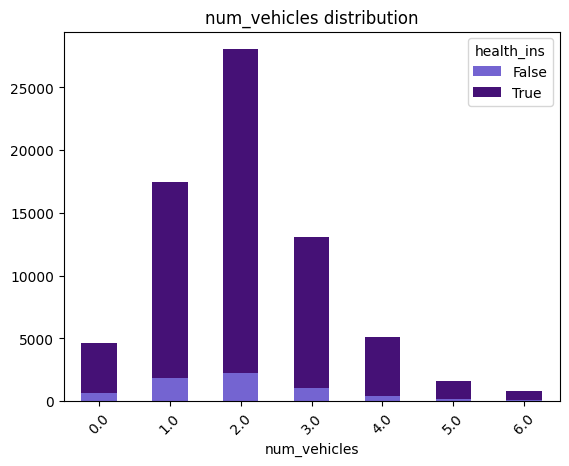

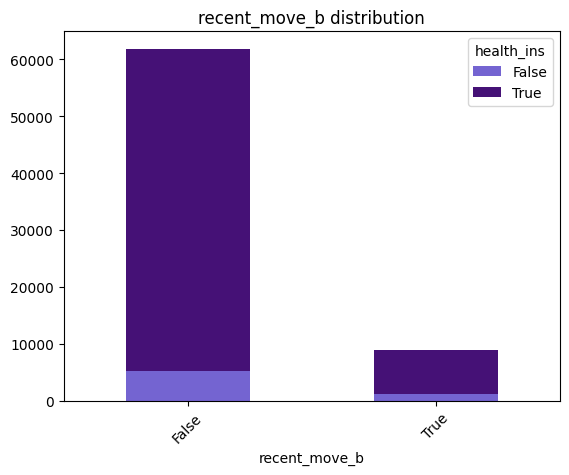

In [228]:
utils.plot_dist('num_vehicles')
utils.plot_dist('recent_move_b')

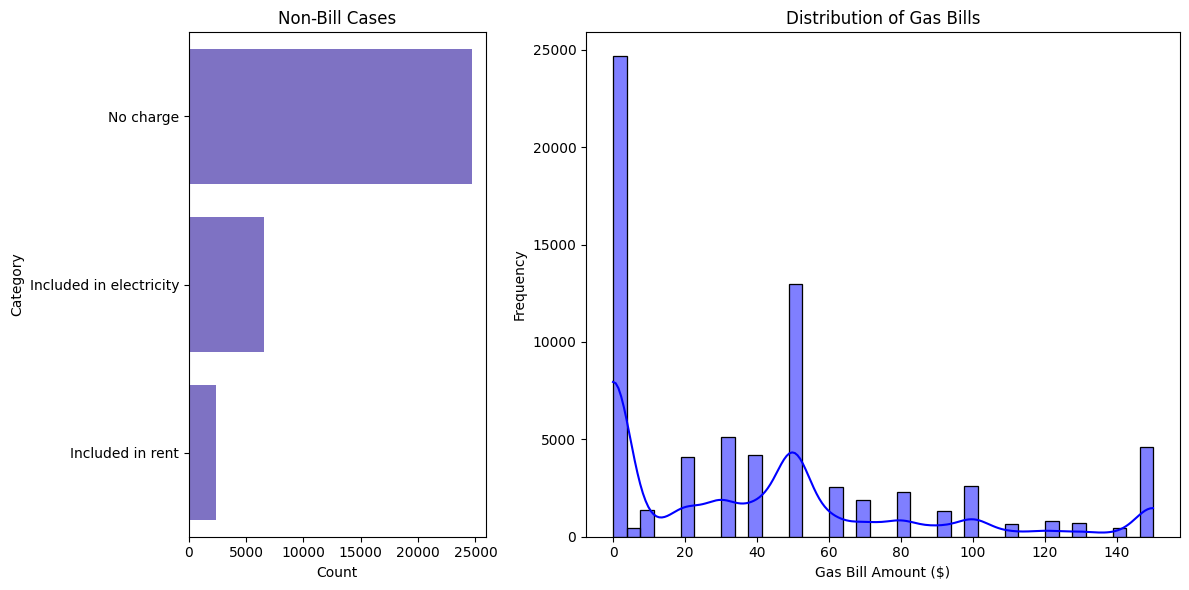

In [229]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]})

# Bar chart for non-bill cases
non_bills = df[df['gas_category'] != 'Actual Bill']
non_bill_counts = non_bills['gas_category'].value_counts()
sns.barplot(x=non_bill_counts.values, y=non_bill_counts.index, ax=axes[0])
axes[0].set_title('Non-Bill Cases')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Category')

# Histogram for actual bills
sns.histplot(df['gas_usage'], bins=40, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Distribution of Gas Bills')
axes[1].set_xlabel('Gas Bill Amount ($)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

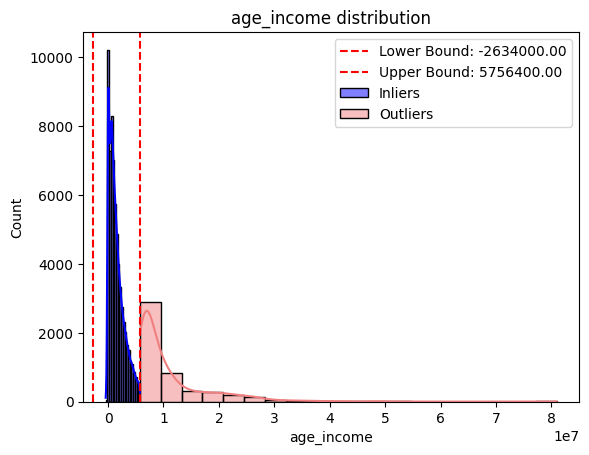

In [230]:
utils.update_df(df)
utils.plot_numeric_dist('age_income')

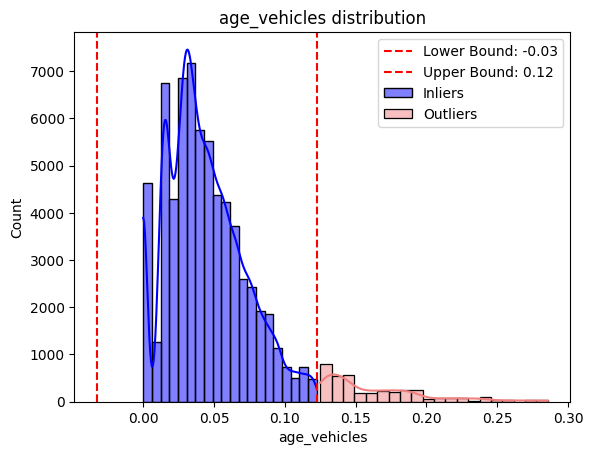

In [231]:
utils.update_df(df)
utils.plot_numeric_dist('age_vehicles')

## **4. Modelling**

First, we defined some helper functions to make the model evaluation less repetitive.

In [232]:
def determine_income_housing(row):
    if row['housing_type_Homeowner with mortgage/loan'] == 1:
        return 1
    elif row['housing_type_Occupied with no rent'] == 1:
        return 0.8
    return 0.6



def preprocess_dataframe(df, _preprocessor):
    _df = df.copy()
    
    x_processed = _preprocessor.fit_transform(_df)
        
    if _preprocessor == tree_preprocessor:
        feature_names = label_features + _preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features).tolist()
    else:
        feature_names = _preprocessor.named_transformers_['onehot'].get_feature_names_out(label_features + categorical_features).tolist()    

    feature_names += numerical_features
        
    # rename health_ins_True to health_ins
    feature_names = [name.replace('health_ins_True', 'health_ins') for name in feature_names]
        
    df_processed = pd.DataFrame(x_processed, columns=feature_names)
    df_processed['income_state'] = df_processed['income'] * df_processed['state_of_res']

    df_processed['income_housing'] = df_processed['income'] * df_processed.apply(determine_income_housing, axis=1)
    
    return df_processed

These functions apply the preprocessing steps for the training datasets.


In [233]:
def classify_split_then_sample(df, preprocessor, sample_function, params, classifier):
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Sample data
    X_resampled, y_resampled = sample_function(X_train, y_train)
    
    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=5)
    
    grid_search.fit(X_resampled, y_resampled)
    
    # Predict
    y_pred = grid_search.predict(X_test)
    
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

In [234]:
def classify_sample_then_split(df, preprocessor, sample_function, params, classifier):
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)
    
    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Sample data
    X_resampled, y_resampled = sample_function(X, y)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=5)
    grid_search.fit(X_train, y_train)
    # Predict
    y_pred = grid_search.predict(X_test)
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

These functions apply the sampling techniques and the training process using grid search to obtain the best hyperparameters while also performing cross validation. They display the evaluation scores and confusion matrix. The first one applies the sampling technique after doing the train-test split while the second one applies it before splitting.

#### **4.1. K-Nearest Neightbour**

In [235]:
KNN_params = {
    'n_neighbors': [1, 3, 5, 7]
}

F1 Score: 0.9447244394802081
Accuracy: 0.94739707559888
Best Parameters: {'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     19219
         1.0       1.00      0.90      0.94     19353

    accuracy                           0.95     38572
   macro avg       0.95      0.95      0.95     38572
weighted avg       0.95      0.95      0.95     38572



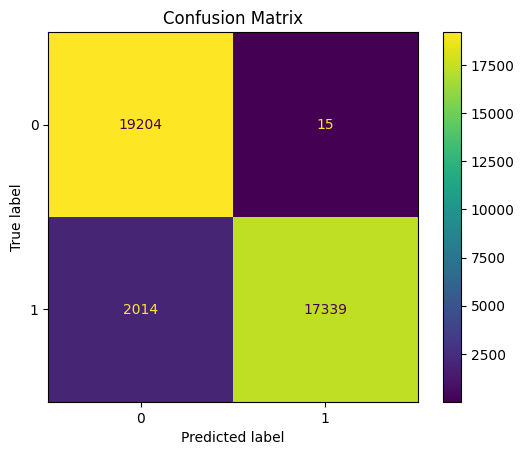

In [236]:
classify_sample_then_split(df, tree_preprocessor, oversample_data, KNN_params, KNeighborsClassifier())

The best results for KNN were achieve using oversampling. This could be due to the fact that oversampling creates new `health_ins=False` entries that are similar to ones that already exist.

#### **4.2. Gaussian Naive Bayes**

In [237]:
gnb_params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

F1 Score: 0.5038919662575576
Accuracy: 0.643457445424505
Best Parameters: {'var_smoothing': 3.511191734215127e-05}
              precision    recall  f1-score   support

         0.0       0.59      0.93      0.72     19025
         1.0       0.85      0.36      0.50     19408

    accuracy                           0.64     38433
   macro avg       0.72      0.65      0.61     38433
weighted avg       0.72      0.64      0.61     38433



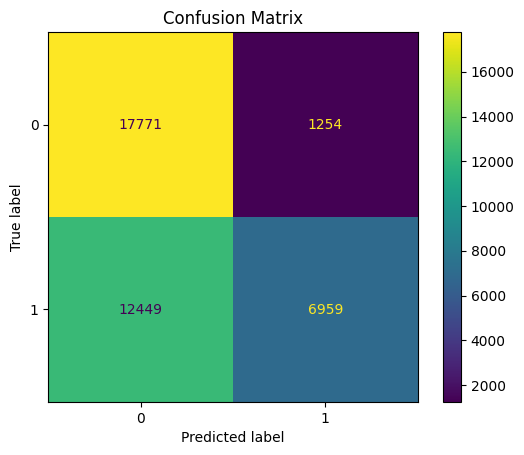

In [238]:
classify_sample_then_split(df, tree_preprocessor, smote_data, gnb_params, GaussianNB())

#### **4.3. Decision Tree**

In [239]:
tree_params = {
    'max_depth': [29],
    'criterion': ['gini'],
    'splitter': ['random'],
    'class_weight': ['balanced']
}

F1 Score: 0.8968675200333022
Accuracy: 0.8968594697265371
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'splitter': 'random'}
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     19025
         1.0       0.91      0.89      0.90     19408

    accuracy                           0.90     38433
   macro avg       0.90      0.90      0.90     38433
weighted avg       0.90      0.90      0.90     38433



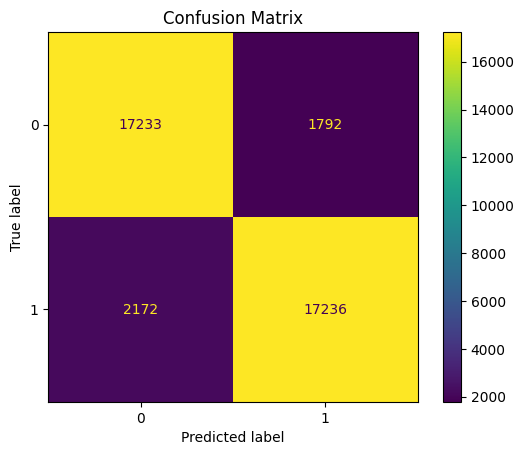

In [240]:
classify_sample_then_split(df, tree_preprocessor, smote_data, tree_params, DecisionTreeClassifier())

#### **4.4. Random Forest**

In [243]:
rf_params = {
    'class_weight': ['balanced'],  
    'criterion': ['gini', 'entropy'],  
    'max_depth': [7, 9],   
    'min_samples_leaf': [1, 2],
    'n_estimators': [200, 300],
    'random_state': [42],
    'bootstrap': [True],
}

F1 Score: 0.8606060606060606
Accuracy: 0.8659485338120886
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 42}
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87     19025
         1.0       0.91      0.82      0.86     19408

    accuracy                           0.87     38433
   macro avg       0.87      0.87      0.87     38433
weighted avg       0.87      0.87      0.87     38433



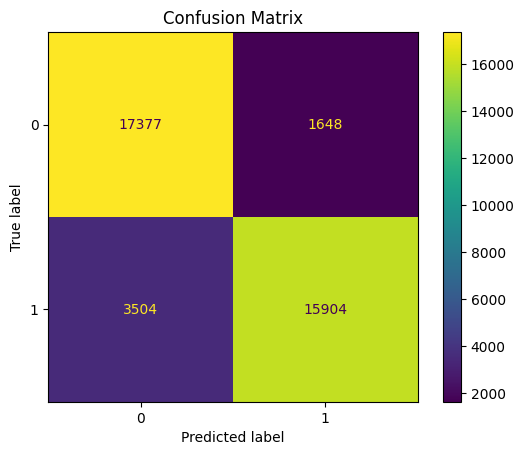

In [244]:
classify_sample_then_split(df, tree_preprocessor, smote_data, rf_params, RandomForestClassifier())

#### **4.5. SVM** 

In [248]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.1],
    'class_weight': ['balanced'],
    'probability': [True]
}

F1 Score: 0.8027631339756408
Accuracy: 0.6931127139018526
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
              precision    recall  f1-score   support

         0.0       0.19      0.76      0.31      1910
         1.0       0.97      0.69      0.80     19303

    accuracy                           0.69     21213
   macro avg       0.58      0.72      0.56     21213
weighted avg       0.90      0.69      0.76     21213



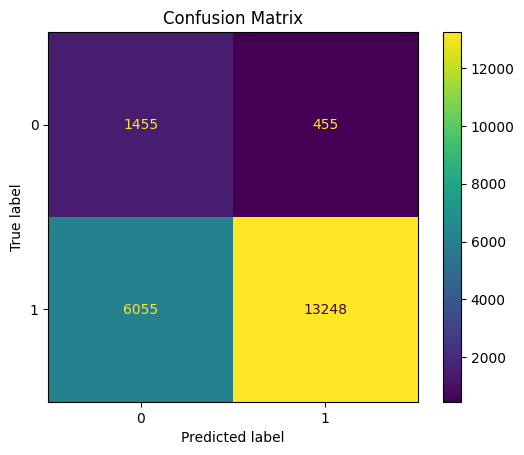

In [249]:
from sklearn.svm import SVC

classify_split_then_sample(df, tree_preprocessor, undersample_data, svm_params, SVC())

Since this classifier is very computationally intensive, we applied undersampling to ensure the training dataset is smaller and balanced.

#### **4.6. Neural Network**

In [ ]:
def create_nn_model():
    nn = Sequential()
    nn.add(layers.Dense(128, activation='relu', input_dim=23)) 
    nn.add(layers.Dense(64, activation='relu'))
    nn.add(layers.Dense(32, activation='relu'))
    nn.add(layers.Dense(1, activation='sigmoid')) 

    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return nn

In [ ]:
def classify_sample_then_split_nn(df,preprocessor,sample_data,nn):
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Sample data
    X_resampled, y_resampled = sample_data(X, y)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    # Train model
    nn.fit(X_train, y_train, epochs=30, batch_size=32)
    
    # Predict
    y_pred = nn.predict(X_test)
    y_pred = (y_pred > 0.5)
    
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 3s 697us/step - accuracy: 0.7018 - loss: 0.5796
Epoch 2/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.7443 - loss: 0.5167
Epoch 3/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step - accuracy: 0.7522 - loss: 0.5003
Epoch 4/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 678us/step - accuracy: 0.7652 - loss: 0.4813
Epoch 5/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 679us/step - accuracy: 0.7882 - loss: 0.4445
Epoch 6/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.8046 - loss: 0.4104
Epoch 7/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 671us/step - accuracy: 0.8210 - loss: 0.3760
Epoch 8/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.8298 - loss: 0.3581
Epoch 9/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.8407 - loss: 0.3368
Epoch 10/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - accuracy: 0.8454 - loss: 0.3257
Epoch 11/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 681us/step - accuracy: 0.8496 - loss: 0.3156
Epoch 12

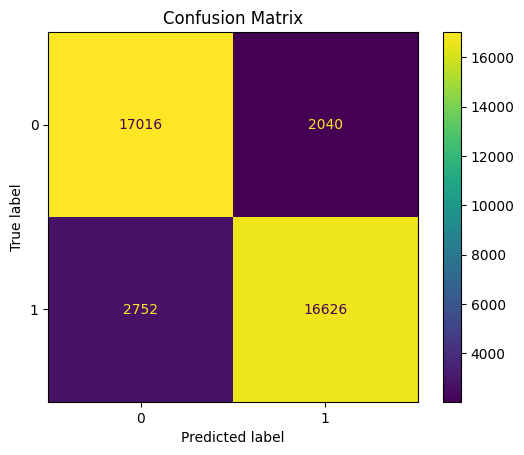

In [ ]:
nn = create_nn_model()

classify_sample_then_split_nn(df, tree_preprocessor, smote_data, nn)

K.clear_session()

#### **4.7. XGBoost**

In [263]:
xgb_params = {
    'max_depth': [7, 9],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200, 300]
}

In [264]:
def classify_sample_then_split_xgb():
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, tree_preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']

    # Sample data
    X_resampled, y_resampled = smote_data(X, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

    # Define the XGBoost classifier and parameter grid
    xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss') 

    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=xgb_params, cv=5, scoring='f1', n_jobs=-1)

    grid_search.fit(X_resampled, y_resampled)

    # Predict
    y_pred = grid_search.predict(X_test)

    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)

    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

c:\Users\Athos\anaconda3\envs\ICD\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:58:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.9374093765103915
Accuracy: 0.9326099966174902
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 2, 'subsample': 0.8}
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93     19025
         1.0       0.88      1.00      0.94     19408

    accuracy                           0.93     38433
   macro avg       0.94      0.93      0.93     38433
weighted avg       0.94      0.93      0.93     38433



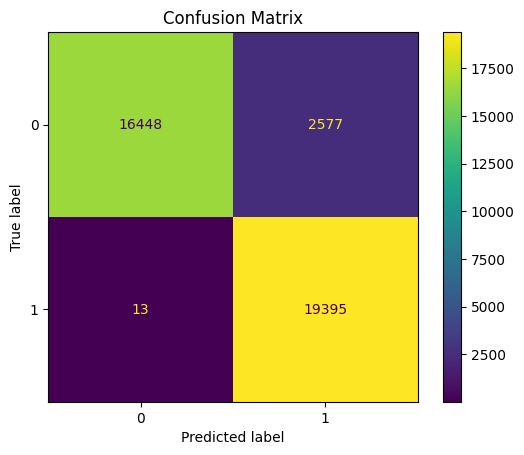

In [265]:
classify_sample_then_split_xgb()

## **5. Submission**

This section corresponds to the methods used to make the submissions to kaggle. It includes training the models with the best parameters we found in the previous section and using them to predict the values on the masked dataset. 

### **5.1. Preprocessing**

In [ ]:
raw_data = pd.read_csv('customer.csv')
masked_df = pd.read_csv('customer_test_masked.csv')

In [ ]:
label_features = ['state_of_res']
categorical_features = ['sex', 'marital_status', 'housing_type', 'gas_category', 'recent_move_b', 'is_employed']
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms', 'age_income']
target_feature = 'health_ins'
id_feature = 'custid'

# Define a preprocessor globally so it can be reused
preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_features),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

def preprocess_dataframe(df, fit_preprocessor=True):
    global preprocessor  # Use the same preprocessor instance
    
    # Drop the target feature for feature processing
    df_features = df.drop(target_feature, axis=1, errors='ignore')
    
    if fit_preprocessor:
        # Fit and transform the preprocessor on training data
        features_processed = preprocessor.fit_transform(df_features)
    else:
        # Only transform using an already fitted preprocessor
        features_processed = preprocessor.transform(df_features)
    
    # Extract feature names from the preprocessor
    feature_names = (
        label_features +
        preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features).tolist() +
        numerical_features +
        [id_feature]
    )
    
    # Create a DataFrame for the processed features
    df_processed = pd.DataFrame(features_processed, columns=feature_names)
    
    # Ensure indices align
    df_processed = df_processed.reset_index(drop=True)
    
    # Add the target feature back if it exists in the original DataFrame
    if target_feature in df.columns:
        df_target = df[target_feature].reset_index(drop=True)
        df_processed[target_feature] = df_target
    
    return df_processed

In [ ]:
def apply_data_engineering_replace(df):
    
    df_replaced = df.copy()
    
    df_replaced.drop(columns=['Unnamed: 0', 'code_column'], inplace=True)

    df_replaced['housing_type'] = df_replaced['housing_type'].fillna(df_replaced['housing_type'].mode()[0])
    
    df_replaced['is_employed'] = df_replaced['is_employed'].fillna(False)
    
    df_replaced['num_vehicles'] = df_replaced['num_vehicles'].fillna(round(df['num_vehicles'].mean(),0))
    
    df_replaced['recent_move_b'] = df_replaced['recent_move_b'].fillna(df_replaced['recent_move_b'].mode()[0])
    df_replaced['recent_move_b'] = df_replaced['recent_move_b'].replace({'T': True, 'F': False})
    
    df_replaced['age'] = df_replaced['age'].replace(0, df_replaced['age'].median())
    df_replaced['age'] = df_replaced['age'].replace(120, df_replaced['age'].median())
    
    df_replaced = handle_gas_feature(df_replaced)
    
    df_replaced['age_income'] = df_replaced.age * df_replaced.income
    
    return df_replaced